# Tutorial : Training Dynap-SE2 Simulator using BPTT

In this tutorial, we will investigate and optimize the firing rate response of a Dynap-SE2 simulator that is fundementally functioning as a spiking neural network (SNN). We will define a single neuron with a single input channel and measure its mean firing rate.

<img src=https://raw.githubusercontent.com/synsense/rockpool/dev/dynapse_support/docs/devices/DynapSE/images/spike_firing.png
 width="1024">

If you're unfamiliar with DynapSim, please first refer to DynapSim tutorial

---
# Setup

### Imports

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Optional
import numpy as np
from tqdm import tqdm
from copy import deepcopy

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Dynap-SE2
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train

# Jax Imports
import jax
from jax.example_libraries.optimizers import adam
import rockpool.training.jax_loss as l

from jax import numpy as jnp

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

# Section 1 : Model Investigatation

In [2]:
dt = 1e-3
n_in = 1
n_rec = 1
n_out = 1
n_syn = 4  # non-changable for now


## Section 1.1 : Model Implementation

In [3]:
simconfig = DynapSimConfig.from_specification(
    shape=(n_in, n_rec, n_out),
    w_in_mask=np.array([[[10, 0, 0, 0]]]),
    w_rec_mask=np.array([[[0, 0, 0, 0]]]),
)


In [4]:
# --- Input Layer --- #
linear_in = LinearJax(
    shape=(n_in, n_rec * n_syn), weight=simconfig.w_in.reshape(n_in, -1), has_bias=False
)
linear_in


LinearJax  with shape (1, 4)

In [5]:
# --- DynapSim Layer --- #
dynapsim = DynapSim.from_DynapSimConfig(
    shape=(n_rec * n_syn, n_rec), has_rec=True, simconfig=simconfig
)
dynapsim


DynapSim  with shape (4, 1)

In [6]:
# --- Model --- #
model = Sequential(linear_in, dynapsim)
# model = jax.jit(model)


## Section 1.2 : Generate Input Spike Train

Generate a random poisson spike train with a mean firing rate of 100 Hz.

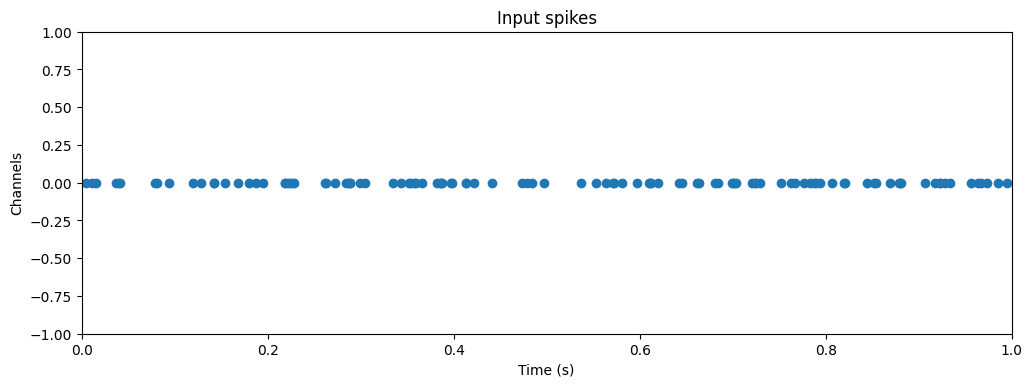

In [7]:
spikes_in = poisson_spike_train(n_channels=1, duration=1.0, rate=120.0, dt=dt, seed=2021)
spike_ts = TSEvent.from_raster(spikes_in[0], name="Input spikes", periodic=True, dt=dt)
spike_ts.plot()


Let's run the model and investigate the output

## Section 1.3 Observe State Evolution Over Time

The Rockpool model simulates the spiking neural network for the duration of the input spike train and produce three output objects

* `out` is the spiking ouput response of the system
* `state` is the resulting state that the network got into, that is the last time step status of the state variables
* `record dictionary` stores the evolution of the currents through time

In [8]:
model.reset_state()
out, state, record_dict = model(spikes_in, record=True)


[ ] Here you can print and investigate the output structure of the model!

### The output Spikes

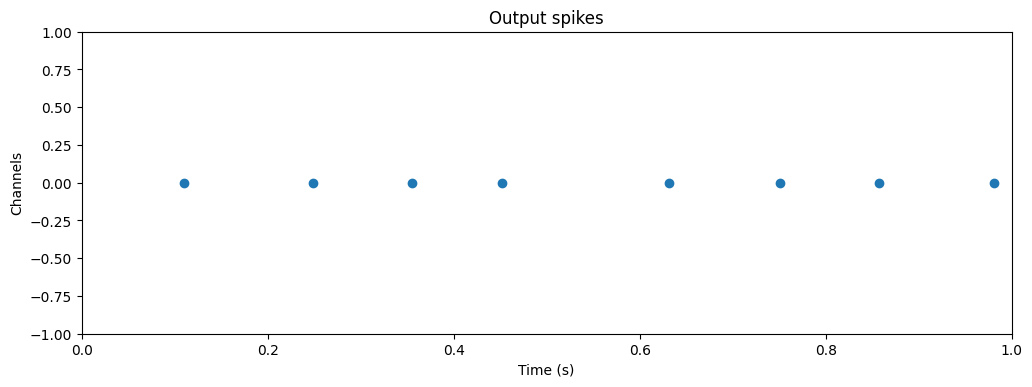

In [9]:
spike_ts_out = TSEvent.from_raster(out[0], name="Output spikes", periodic=True, dt=dt)
spike_ts_out.plot()


### Membrane Current and Membrane Potential

non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 1000. Channels: 1

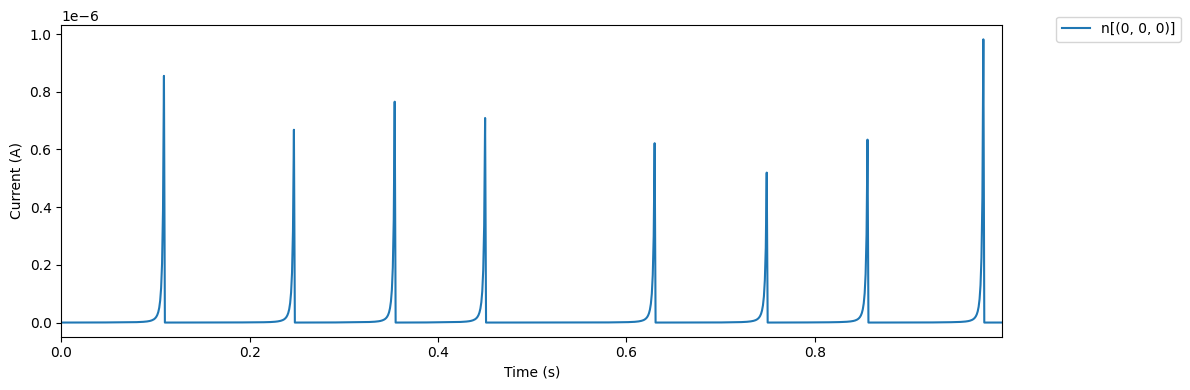

In [10]:
Figure.plot_Ix(record_dict["1_DynapSim"]["imem"][0], idx_map=simconfig.router.idx_map)


non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 1000. Channels: 1

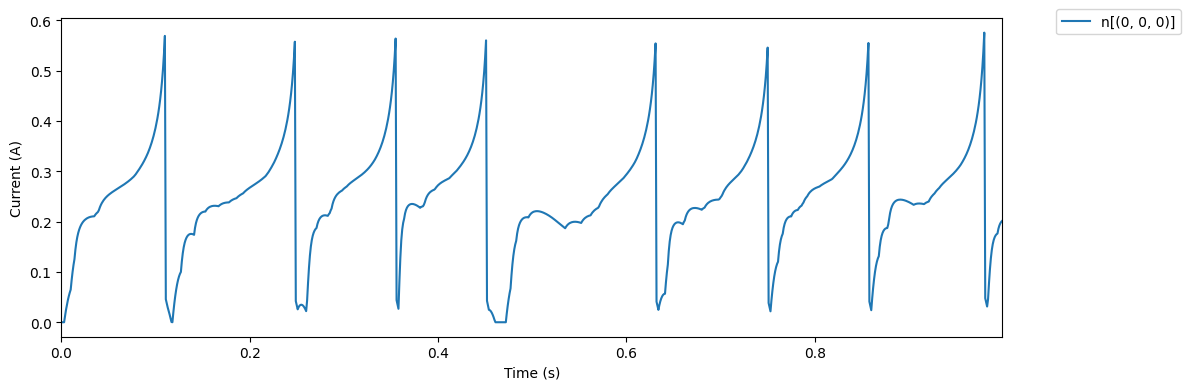

In [11]:
Figure.plot_Ix(record_dict["1_DynapSim"]["vmem"][0], idx_map=simconfig.router.idx_map)


### Synaptic Current

(non-periodic TSContinuous object `$I_{AMPA}$ n[0]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 1. Events: 109,
 ['s[0]'])

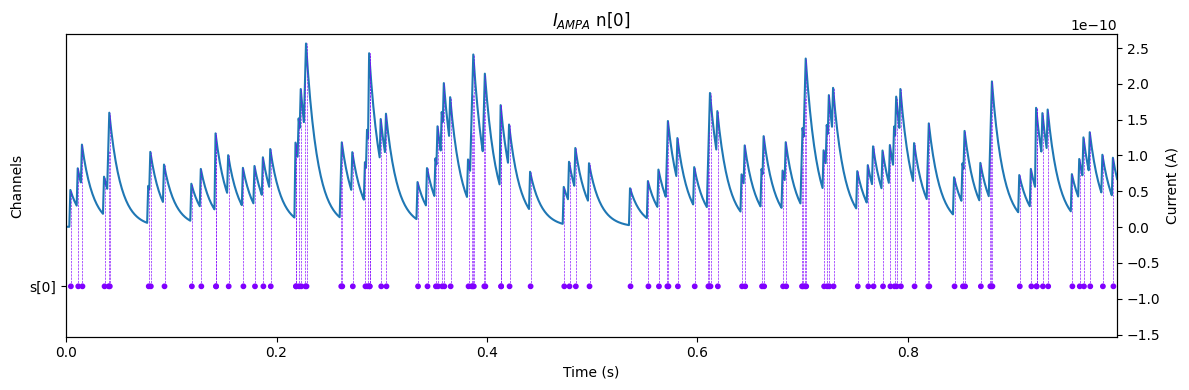

In [12]:
Figure.plot_Isyn_trace(
    input_ts=spike_ts,
    output_ts=spike_ts_out,
    record_dict=record_dict["1_DynapSim"],
    post=0,
    syn_name="AMPA",
    router=simconfig.router,
)


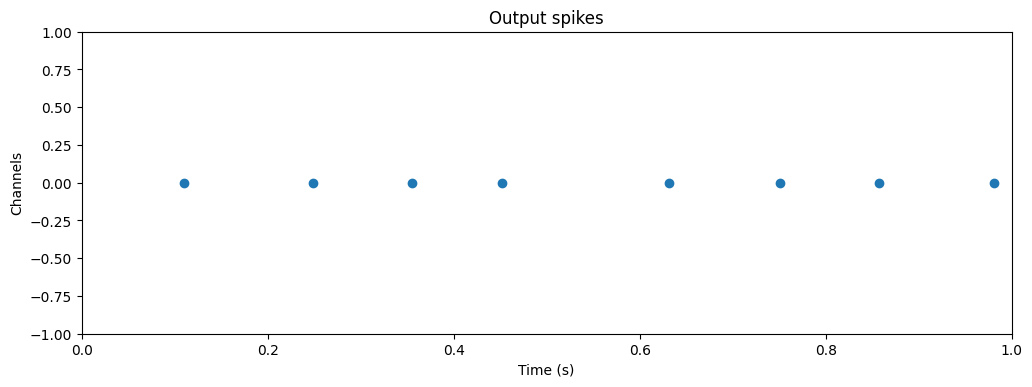

In [13]:
spike_ts_out = TSEvent.from_raster(out[0], name="Output spikes", periodic=True, dt=dt)
spike_ts_out.plot()


---
## Section 2: Define the Optimization Task

We want the neuron to fire at 5 Hz given the 20 Hz input. In order to reach to this target firing rate, we need to define a loss function, such that minimising the loss will lead to our desired output rate.



### Section 2.1 : Target

Here we define the target firing rate.

In [14]:
target = 5.0


### Section 2.2 : Loss Function

We use Mean squared error (MSE), which is one of the most commonly used loss function for regression tasks in machine learning. The loss is given by the mean of the squared differences between true and predicted values for the rate of the neuron.

MSE Loss : $ l = (r - \hat{r})^ 2 $

In [15]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

# params = {"0_LinearJax": model.parameters()["0_LinearJax"], "1_DynapSim": {}}

# - Generate a set of pre-configured bounds
# lower_bounds, upper_bounds = make_bounds(params)
# print("lower_bounds: ", lower_bounds, "upper_bounds: ", upper_bounds)


In [16]:
# lower_bounds["0_LinearJax"]["weight"] = 5e-13
# print("lower_bounds: ", lower_bounds, "upper_bounds: ", upper_bounds)


In [17]:
# from functools import partial
# from jax import jit

# @partial(jit, static_argnums=(0,))
def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    # net = net.reset_state()

    # # - Assign the provided parameters to the network
    # net = net.set_attributes(parameters)

    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)
    rate_out = jnp.sum(output)

    # - Compute a loss value w.r.t. the target output
    # bounds = bounds_cost(parameters, lower_bounds, upper_bounds) * 1e3

    # - Compute a loss value w.r.t. the target output
    # return l.mse(rate_out, target) + bounds
    return l.mse(rate_out, target)


---
## Section 3 : Training a Spiking Neural Network

So far we have explored spiking rockpool modules and now we're ready to optimize our network. Let's first re-initialize the linear layer.

In [18]:
# Reinitialize the model

# linear_in = LinearJax(
#     shape=(n_in, n_rec * n_syn), weight=simconfig.w_in.reshape(n_in, -1), has_bias=False
# )
# dynapsim = DynapSim.from_DynapSimConfig(
#     shape=(n_rec * n_syn, n_rec), has_rec=True, simconfig=simconfig
# )
# model = Sequential(linear_in, dynapsim)
# params = {"0_LinearJax": model.parameters()["0_LinearJax"], "1_DynapSim": {}}


### Section 3.1 : Training Loop

We are using the MSE loss and the Adam optimizer for training.

In [19]:
# - Initialise the optimiser with the initial parameters
# - Get the optimiser functions
init_fun, update_fun, get_params = adam(5e-11)
params = deepcopy(model.parameters())
opt_state = init_fun(params)

# - Get a compiled value-and-gradient function
# loss_vgf = jax.value_and_grad(loss_mse)
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
num_epochs = 100


In [20]:
get_params(opt_state)


{'0_LinearJax': {'weight': array([[1.e-08, 0.e+00, 0.e+00, 0.e+00]], dtype=float32)},
 '1_DynapSim': {'Idc': array([5.e-13], dtype=float32),
  'If_nmda': array([5.e-13], dtype=float32),
  'Igain_ahp': array([2.8368794e-08], dtype=float32),
  'Igain_ampa': array([8.687944e-09], dtype=float32),
  'Igain_gaba': array([8.865248e-10], dtype=float32),
  'Igain_mem': array([2.1276595e-11], dtype=float32),
  'Igain_nmda': array([8.865248e-10], dtype=float32),
  'Igain_shunt': array([8.687944e-09], dtype=float32),
  'Ipulse': array([3.5e-08], dtype=float32),
  'Ipulse_ahp': array([3.5e-07], dtype=float32),
  'Iref': array([5.25e-10], dtype=float32),
  'Ispkthr': array([1.e-06], dtype=float32),
  'Itau_ahp': array([2.8368795e-11], dtype=float32),
  'Itau_ampa': array([8.6879434e-11], dtype=float32),
  'Itau_gaba': array([8.865248e-12], dtype=float32),
  'Itau_mem': array([5.3191488e-12], dtype=float32),
  'Itau_nmda': array([8.865248e-12], dtype=float32),
  'Itau_shunt': array([8.6879434e-11], d

In [21]:
model[1].simulation_parameters()

{'C_ahp': DeviceArray([4.e-11], dtype=float32),
 'C_ampa': DeviceArray([2.45e-11], dtype=float32),
 'C_gaba': DeviceArray([2.5e-11], dtype=float32),
 'C_nmda': DeviceArray([2.5e-11], dtype=float32),
 'C_pulse_ahp': DeviceArray([5.e-13], dtype=float32),
 'C_pulse': DeviceArray([5.e-13], dtype=float32),
 'C_ref': DeviceArray([1.5e-12], dtype=float32),
 'C_shunt': DeviceArray([2.45e-11], dtype=float32),
 'C_mem': DeviceArray([3.e-12], dtype=float32),
 'Io': DeviceArray([5.e-13], dtype=float32),
 'kappa_n': DeviceArray([0.75], dtype=float32),
 'kappa_p': DeviceArray([0.66], dtype=float32),
 'Ut': DeviceArray([0.025], dtype=float32),
 'Vth': DeviceArray([0.7], dtype=float32),
 'dt': 0.001}

In [22]:
params

{'0_LinearJax': {'weight': array([[1.e-08, 0.e+00, 0.e+00, 0.e+00]], dtype=float32)},
 '1_DynapSim': {'w_rec': array([[[0., 0., 0., 0.]]], dtype=float32),
  'Idc': array([5.e-13], dtype=float32),
  'If_nmda': array([5.e-13], dtype=float32),
  'Igain_ahp': array([2.8368794e-08], dtype=float32),
  'Igain_ampa': array([8.687944e-09], dtype=float32),
  'Igain_gaba': array([8.865248e-10], dtype=float32),
  'Igain_nmda': array([8.865248e-10], dtype=float32),
  'Igain_shunt': array([8.687944e-09], dtype=float32),
  'Igain_mem': array([2.1276595e-11], dtype=float32),
  'Ipulse_ahp': array([3.5e-07], dtype=float32),
  'Ipulse': array([3.5e-08], dtype=float32),
  'Iref': array([5.25e-10], dtype=float32),
  'Ispkthr': array([1.e-06], dtype=float32),
  'Itau_ahp': array([2.8368795e-11], dtype=float32),
  'Itau_ampa': array([8.6879434e-11], dtype=float32),
  'Itau_gaba': array([8.865248e-12], dtype=float32),
  'Itau_nmda': array([8.865248e-12], dtype=float32),
  'Itau_shunt': array([8.6879434e-11],

In [23]:
params

{'0_LinearJax': {'weight': array([[1.e-08, 0.e+00, 0.e+00, 0.e+00]], dtype=float32)},
 '1_DynapSim': {'w_rec': array([[[0., 0., 0., 0.]]], dtype=float32),
  'Idc': array([5.e-13], dtype=float32),
  'If_nmda': array([5.e-13], dtype=float32),
  'Igain_ahp': array([2.8368794e-08], dtype=float32),
  'Igain_ampa': array([8.687944e-09], dtype=float32),
  'Igain_gaba': array([8.865248e-10], dtype=float32),
  'Igain_nmda': array([8.865248e-10], dtype=float32),
  'Igain_shunt': array([8.687944e-09], dtype=float32),
  'Igain_mem': array([2.1276595e-11], dtype=float32),
  'Ipulse_ahp': array([3.5e-07], dtype=float32),
  'Ipulse': array([3.5e-08], dtype=float32),
  'Iref': array([5.25e-10], dtype=float32),
  'Ispkthr': array([1.e-06], dtype=float32),
  'Itau_ahp': array([2.8368795e-11], dtype=float32),
  'Itau_ampa': array([8.6879434e-11], dtype=float32),
  'Itau_gaba': array([8.865248e-12], dtype=float32),
  'Itau_nmda': array([8.865248e-12], dtype=float32),
  'Itau_shunt': array([8.6879434e-11],

In [24]:
# - Loop over iterations
pbar = tqdm(range(num_epochs))
for i_trial in pbar:

    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, model, spikes_in, target)

    # - Update the optimiser
    opt_state = update_fun(i_trial, grads, opt_state)

    # - Keep track of the loss
    _loss = loss_val.item()
    loss_t.append(loss_val.item())

    # Report grad
    _grad_report = np.array(grads["0_LinearJax"]["weight"])

    _p = params["0_LinearJax"]["weight"]
    pbar.set_description(f"Loss = {_loss},  Grad = {_grad_report}, Weight = {_p}")

    if _loss == 0:
        break


  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: full requires ndarray or scalar arguments, got <class 'NoneType'> at position 0.

In [ ]:
get_params(opt_state)


{'0_LinearJax': {'weight': DeviceArray([[1.4999996e-08, 4.9999618e-09, 4.9999618e-09, 4.9999618e-09]],            dtype=float32)}}

### Section 3.2 : Results

Let's check what happened during and after training. First we can see that the loss converges to zero. 

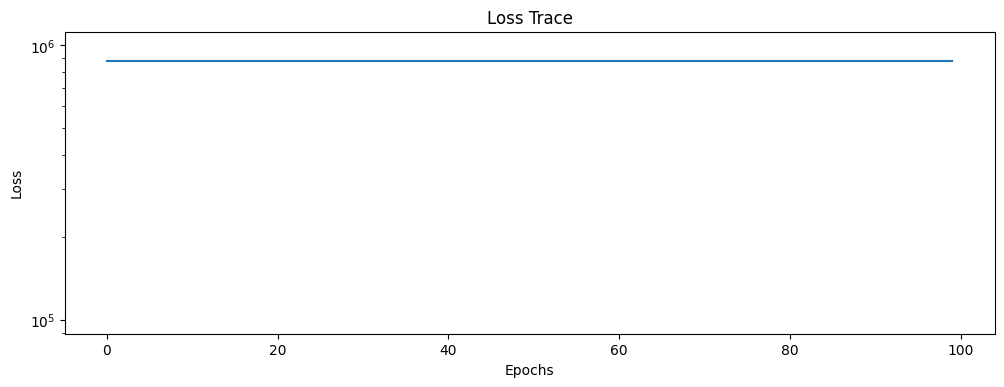

In [ ]:
plt.plot(loss_t)
plt.title("Loss Trace")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")


Finally, let's run the optimized module and prove that it expresses a firing rate of 5 Hz.

In [ ]:
model = model.set_attributes(get_params(opt_state))
model.reset_state()
out, state, rec = model(spikes_in, record=True)
spike_ts_out = TSEvent.from_raster(out[0], name="Output spikes", periodic=True, dt=dt)
spike_ts_out.plot()


ZeroDivisionError: division by zero

non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 1000. Channels: 1

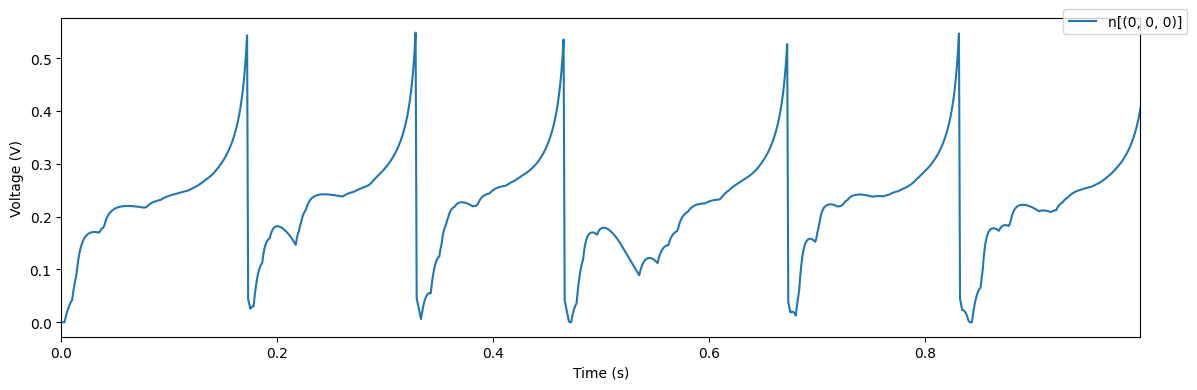

In [ ]:
Figure.plot_Ix(rec["1_DynapSim"]["vmem"][0], idx_map=simconfig.router.idx_map, ylabel="Voltage (V)")
